In [1]:
## Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

Path = '/Users/Chun'

In [2]:
## Load tissue data; Prepared for K-Means CLustering
reads = pd.read_csv(os.path.join(Path, 'TissueData/', 'expr.txt'), sep = '\t', index_col = 0)
labels = pd.read_csv(os.path.join(Path, 'TissueData/', 'class_labels.txt'), sep = '\t', index_col = 0)
reads.index.name = None
labels.index.name = None
df = reads.transpose() # switch x and y 

df[0:7]
df[0:7].reset_index(drop=True) # df.index: original sample ID

,ENSG00000104879.4,ENSG00000143632.10,ENSG00000244734.2,ENSG00000188536.8,ENSG00000206172.4,ENSG00000111245.10,ENSG00000198125.8,ENSG00000101470.5,ENSG00000196091.8,ENSG00000258444.1,...,ENSG00000185482.3,ENSG00000196616.8,ENSG00000166819.7,ENSG00000170807.11,ENSG00000255594.1,ENSG00000187116.9,ENSG00000142748.8,ENSG00000109846.3,ENSG00000186439.8,ENSG00000198467.9
0,-0.465199,-0.410790,-1.030945,-0.951705,-0.917707,-0.606651,-0.526257,-0.460408,-0.582136,-0.526867,...,-0.577896,1.545367,2.016217,-0.545215,0.009151,-0.183529,-0.265376,0.834124,-0.607440,-0.149653
1,-0.279405,-0.140903,-0.742621,-0.821766,-0.885428,0.015065,-0.085238,-0.223476,-0.412443,-0.100601,...,-0.585211,0.886398,1.000392,-0.405292,-0.200806,-0.827298,-0.882116,0.152687,-0.493944,0.386987
2,-0.797181,-0.904178,-0.566096,-0.461757,-0.569051,-0.815001,-0.765842,-0.565326,-0.668160,-0.788854,...,-0.148299,0.831919,1.579891,-0.586510,0.604792,0.004059,-0.873982,0.150883,-0.607523,0.032768
3,-0.508316,-0.463078,-0.575971,-0.600198,-0.735357,-0.518046,-0.591824,-0.559943,-0.586726,-0.629924,...,-0.757595,1.445621,2.083917,-0.554004,-0.335360,-0.409939,0.512259,0.313072,-0.582678,-0.182845
4,-0.373773,-0.627133,-0.479516,-0.527701,-0.487240,-0.691971,-0.548148,-0.499672,-0.498334,-0.692632,...,-0.825380,1.538461,2.166326,-0.553141,-0.480873,-0.655719,0.259930,0.979166,-0.481038,-0.109569
5,-0.616070,-0.568117,0.350760,0.386892,0.287057,-0.526880,-0.567123,-0.483364,-0.605354,-0.506264,...,-0.715364,1.570346,2.304612,-0.563343,-0.396775,-0.191949,-0.039604,0.872478,-0.403912,-0.422148
6,-0.415944,-0.410293,-0.883396,-0.815232,-0.879451,-0.618682,-0.496302,-0.329493,-0.555064,-0.677380,...,-0.587717,1.104969,1.876306,-0.568961,0.136254,-0.525444,-0.889272,0.204192,-0.545596,0.082035


In [3]:
## Part 1: Assign each tissue sample to the nearest cluster  

def assign_cluster(center, s):
    # Calculate the distance between tissue sample point to the centroid of cluster
    CSR = center.apply(lambda x: np.sum((np.array(s)-np.array(x))**2), axis=1) # df.apply: Apply a function along an axis of the DataFrame
                                                                         # axis = 1: apply function to each row; axis = 0: to each column
    CSR = list(CSR) # remove the index column for ordering
    s_cluster = CSR.index(min(CSR)) # Find the min CSR and assign the tissue sample to that cluster
    return s_cluster

In [4]:
## Part 2: For each cluster, recalculate the new centroid based on the mean of all points in this cluster
import collections

def K_Means(df, c, center, maxit):
    n, d = df.shape # n = number of rows; d = number of columns
    k=0
    while k < maxit:
        New_Cluster = df.apply(lambda x: assign_cluster(center, x), axis=1)
        df_copy = df.copy() # Modify df_copy, so original df won't be changed
        df_copy['Cluster'] = New_Cluster # Add new column of clusters to the data frame
        center = df_copy.groupby(['Cluster']).mean() # Within each cluster, take the average of all sample points to get the new centroid
        center.index.name = None
        k +=1
    New_Cluster = df.apply(lambda x: assign_cluster(center, x), axis=1)
    print (collections.Counter(New_Cluster)) # Count the number of samples in a specific cluster
    return {'Cluster':df_copy['Cluster'], 'center': center}  

In [5]:
## Part 3: Choose number of clusters, k (Use BIC score as a criteria)
def BIC(df, model):
    # BIC = -2 log(likelihood) + kd logn (Assume all samples are in Gaussian distribution &　are centered to the centroid of the cluster)
    #     = sum (x_i - c_{x_i})^2 + kd log n 
        
    n, d = df.shape
    k = len(np.unique(model['Cluster']))
    samples = df.index # Original sample ID
    distance_sum = 0
    for s in samples:
        xi = df.loc[s] # DataFrame.loc: access groups of samples using labels
                       # xi: 100 genes values of a specific sample 
        c_xi =  model['center'].loc[model['Cluster'].loc[s]] # Centroid of the cluster
        d = np.sum([x**2 for x in (np.array(xi)-np.array(c_xi))])
        distance_sum += d
    BIC = distance_sum + k*d*np.log(n)
    return BIC

Counter({0: 1382, 1: 434})
The model for 2 centers has BIC = 81741.84489222299
Counter({0: 992, 1: 431, 2: 393})
The model for 3 centers has BIC = 38442.26447902154
Counter({2: 702, 1: 430, 0: 359, 3: 325})
The model for 4 centers has BIC = 40081.727793000624
Counter({2: 688, 1: 430, 3: 324, 0: 193, 4: 181})
The model for 5 centers has BIC = 39883.57200293606
Counter({1: 430, 2: 393, 3: 323, 5: 320, 4: 176, 0: 174})
The model for 6 centers has BIC = 15620.28789645723
Counter({6: 642, 1: 431, 2: 393, 0: 109, 4: 85, 3: 79, 5: 77})
The model for 7 centers has BIC = 27614.017175604527
Counter({6: 642, 1: 431, 2: 393, 7: 114, 4: 89, 5: 61, 3: 50, 0: 36})
The model for 8 centers has BIC = 27556.983420294833
Counter({6: 642, 1: 431, 2: 393, 8: 87, 7: 85, 4: 55, 3: 54, 5: 35, 0: 34})
The model for 9 centers has BIC = 27460.814231634686
Counter({6: 642, 1: 431, 2: 393, 9: 69, 8: 58, 3: 54, 7: 52, 4: 51, 5: 34, 0: 32})
The model for 10 centers has BIC = 27428.412927454134


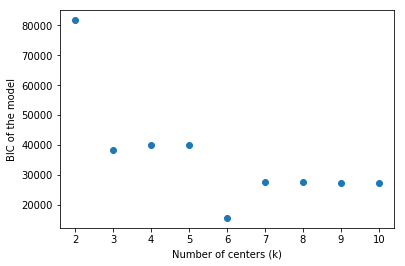

In [6]:
## Output 1: Plot BIC v.s k; Find the optimum k value
# A. Determine BIC at number of clusters: k = 2 to 10
bic = list()
for k in range(2,11):
    # Use first k tissue samples as initial cluster centers; each center is defined with 100 genes (imagine as 100 dimension)
    model = K_Means(df, c = k, center = df[0:k].reset_index(drop=True), maxit=10)
    bici = BIC(df, model)
    print ('The model for {i} centers has BIC = {f}'.format(i=k, f=BIC(df, model)))
    bic.append([bici])
## B. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
    
ax.scatter(range(2,11),bic)
ax.set_xlabel('Number of centers (k)')
ax.set_ylabel('BIC of the model')
    
fig.savefig('Kmeans_BIC.png')

In [7]:
## Output 2: Data visualization
 # A. Find the first two principal components

from numpy import linalg
k = 6
model = K_Means(df, c = k, center = df[0:k].reset_index(drop=True), maxit=10)
U, D, Vt = linalg.svd(df, full_matrices = 1)
V = np.transpose(Vt)
T = np.dot(np.array(df),V)
PC1, PC2 = U[:,0], U[:,1] 

Counter({1: 430, 2: 393, 3: 323, 5: 320, 4: 176, 0: 174})


In [8]:
def plot_modules(PC1, PC2, assignment, truecluster):
    
    colormap = ['b','g','r','c','m','y','k']
    markermap =['x','o','*','v','+']
    
    ## assignemtn to modules
    module_n = len(assignment.unique())
    handles = list()
    for k in range(module_n):
        m = np.where(assignment == k)[0]
        handles.append(plt.scatter(PC1[m], PC2[m], color = colormap[k]))
    labels = ['Module' + str(x) for x in range(module_n)]
    plt.legend(handles, labels)
    plt.title('Assigned Tissue Clusters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
    
    ## true modules
    true_n = len(truecluster.unique())
    handles = list()
    for k in range(true_n):
        m = np.where(truecluster == k)[0]
        handles.append(plt.scatter(PC1[m], PC2[m], marker = markermap[k]))
    labels = ['Tissue' + str(x) for x in range(module_n)]
    plt.legend(handles, labels)
    plt.title('True Tissue Clusters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

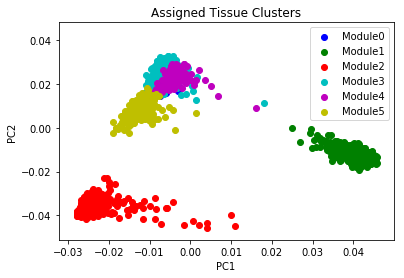

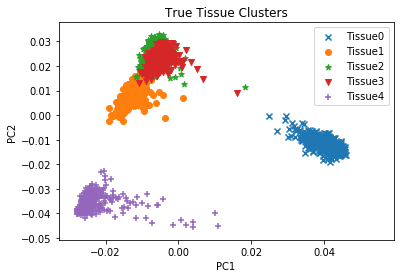

In [9]:
plot_modules(PC1, PC2, model['Cluster'], labels['tissue'])